In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
#import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
#from sklearn.metrics import classification_report, log_loss, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
import datetime
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
# Load the TensorBoard notebook extension
%load_ext tensorboard

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
class_names = ['glioma','meningioma','notumor','pituitary']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (128, 128)

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    TrainF=r"/kaggle/input/brain-tumor-mri-dataset/Training"
    TestF=r"/kaggle/input/brain-tumor-mri-dataset/Testing"
    datasets =  [TrainF,TestF]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading /kaggle/input/brain-tumor-mri-dataset/Training


100%|██████████| 1321/1321 [00:12<00:00, 104.24it/s]


Loading /kaggle/input/brain-tumor-mri-dataset/Testing


100%|██████████| 300/300 [00:02<00:00, 110.32it/s]


In [5]:
print((x_train.shape, y_train.shape), (x_test.shape, y_test.shape))

((5712, 128, 128, 3), (5712,)) ((1311, 128, 128, 3), (1311,))


In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [14]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel


In [15]:
print("building the involution model...")

inputs = keras.Input(shape=(128, 128, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(4)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="SGD",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))
#train,validation_data= val, epochs=10,verbose=1


building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20
179/179 [==============================] - 7s 25ms/step - loss: 1.1779 - accuracy: 0.4317 - val_loss: 1.2130 - val_accuracy: 0.6163
Epoch 2/20
179/179 [==============================] - 4s 21ms/step - loss: 0.8314 - accuracy: 0.6826 - val_loss: 0.7906 - val_accuracy: 0.6888
Epoch 3/20
179/179 [==============================] - 4s 20ms/step - loss: 0.6748 - accuracy: 0.7488 - val_loss: 0.6685 - val_accuracy: 0.7361
Epoch 4/20
179/179 [==============================] - 4s 23ms/step - loss: 0.5441 - accuracy: 0.8009 - val_loss: 0.6549 - val_accuracy: 0.7506
Epoch 5/20
179/179 [==============================] - 4s 21ms/step - loss: 0.4436 - accuracy: 0.8337 - val_loss: 0.4959 - val_accuracy: 0.8101
Epoch 6/20
179/179 [==============================] - 4s 21ms/step - loss: 0.3414 - accuracy: 0.8785 - val_loss: 0.4771 - val_accuracy: 0.8291
Epoch 7/20
179/179 [==============================] -

In [16]:
inv_model.evaluate(x_test, y_test)


41/41 [==============================] - 0s 7ms/step - loss: 0.3184 - accuracy: 0.9062


[0.31840550899505615, 0.9061784744262695]

In [10]:
print("building the convolution model...")
conv_model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3), padding="same"),
        keras.layers.ReLU(name="relu1"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu2"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu3"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(4),
    ]
)

# Compile the mode with the necessary loss function and optimizer.
print("compiling the convolution model...")
conv_model.compile(
    optimizer="SGD",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train the model.
print("conv model training...")
conv_hist = conv_model.fit(x_train, y_train, epochs=20,batch_size=32, validation_data=(x_test, y_test))


building the convolution model...
compiling the convolution model...
conv model training...
Epoch 1/20
179/179 [==============================] - 5s 18ms/step - loss: 0.9753 - accuracy: 0.5800 - val_loss: 0.9931 - val_accuracy: 0.5423
Epoch 2/20
179/179 [==============================] - 2s 12ms/step - loss: 0.6858 - accuracy: 0.7297 - val_loss: 0.7574 - val_accuracy: 0.7193
Epoch 3/20
179/179 [==============================] - 2s 14ms/step - loss: 0.5557 - accuracy: 0.7871 - val_loss: 0.5775 - val_accuracy: 0.7696
Epoch 4/20
179/179 [==============================] - 2s 13ms/step - loss: 0.4677 - accuracy: 0.8255 - val_loss: 0.6709 - val_accuracy: 0.7285
Epoch 5/20
179/179 [==============================] - 2s 12ms/step - loss: 0.4085 - accuracy: 0.8449 - val_loss: 0.4989 - val_accuracy: 0.8047
Epoch 6/20
179/179 [==============================] - 2s 12ms/step - loss: 0.3585 - accuracy: 0.8664 - val_loss: 0.4551 - val_accuracy: 0.8162
Epoch 7/20
179/179 [==============================

In [11]:
conv_model.evaluate(x_test, y_test)

41/41 [==============================] - 0s 6ms/step - loss: 0.2782 - accuracy: 0.9092


[0.2782115936279297, 0.909229576587677]

In [19]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 relu1 (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 relu2 (ReLU)                (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [20]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 128, 128, 3),     26        
                              (None, 128, 128, 9, 1,             
                             1))                                 
                                                                 
 re_lu_3 (ReLU)              (None, 128, 128, 3)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 3)        0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 64, 64, 3),       26        
                              (None, 64, 64, 9, 1, 1)    

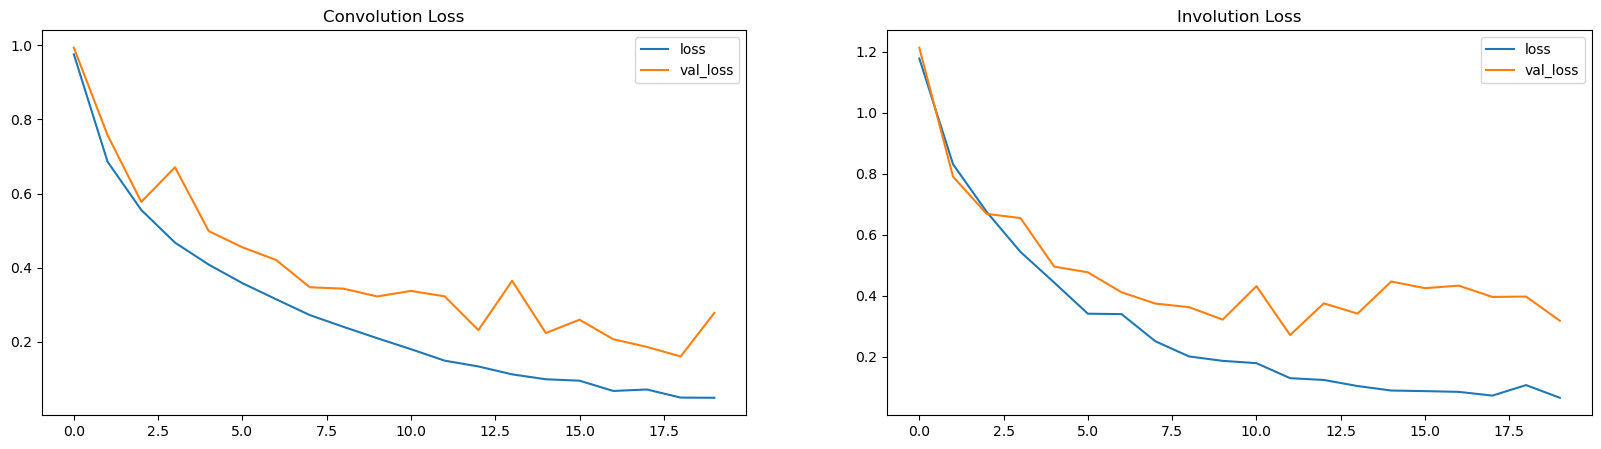

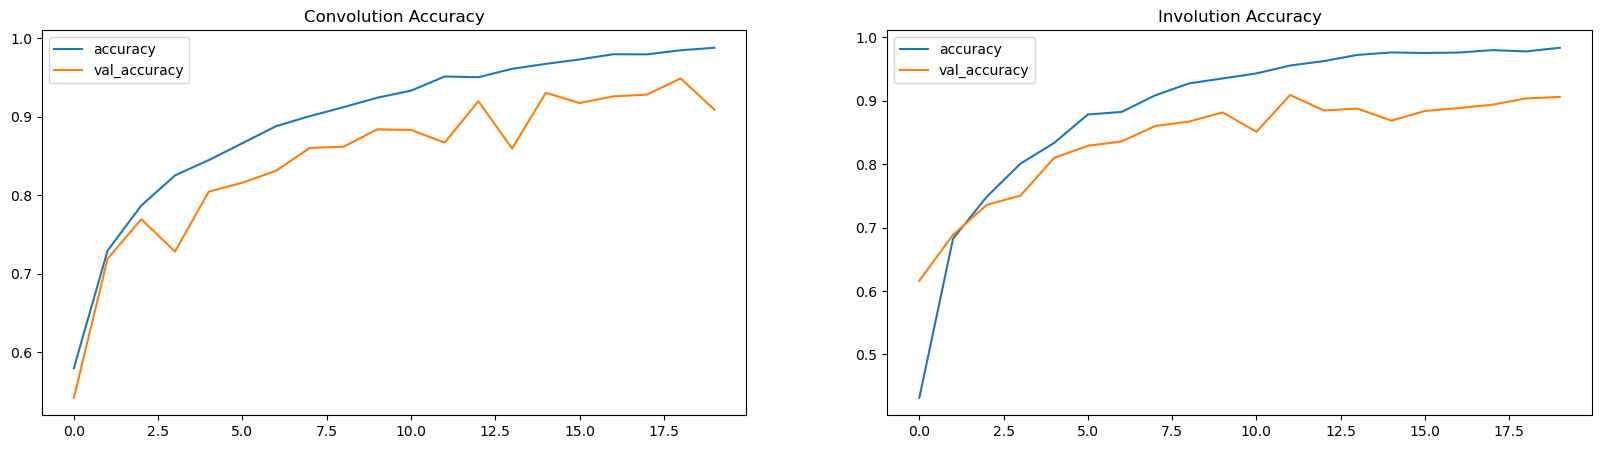

In [17]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.show()

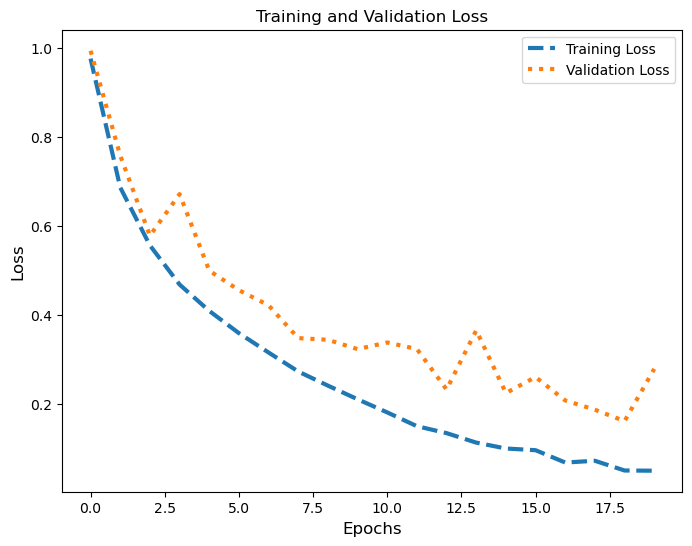

In [50]:
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(conv_hist.history['loss'], label='Training Loss',linewidth=3, linestyle='--')

# Plot validation loss
plt.plot(conv_hist.history['val_loss'], label='Validation Loss', linewidth=3, linestyle=':')

# Set labels and title
plt.xlabel('Epochs', fontdict={'fontsize': 12, 'fontfamily': 'Arial'})
#plt.xlabel('Epoch')
plt.ylabel('Loss', fontdict={'fontsize': 12, 'fontfamily': 'Arial'})
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

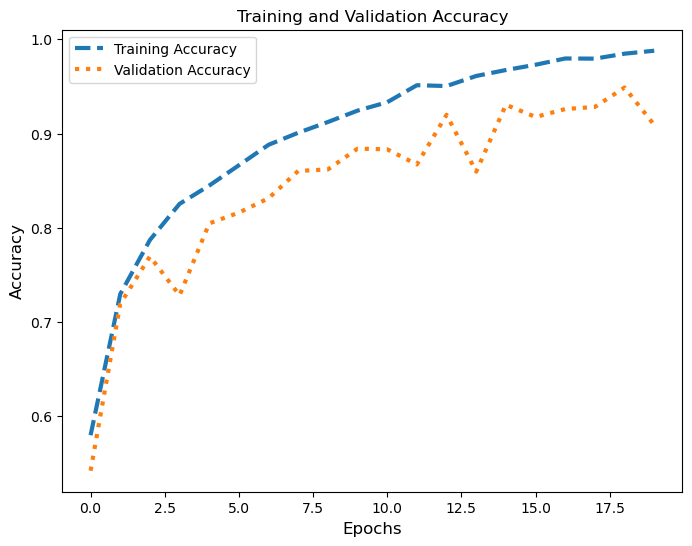

In [51]:
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(conv_hist.history['accuracy'], label='Training Accuracy',linewidth=3,  linestyle='--')

# Plot validation loss
plt.plot(conv_hist.history['val_accuracy'], label='Validation Accuracy',linewidth=3,  linestyle=':')

# Set labels and title
plt.xlabel('Epochs', fontdict={'fontsize': 12, 'fontfamily': 'Arial'})
plt.ylabel('Accuracy', fontdict={'fontsize': 12, 'fontfamily': 'Arial'})
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [52]:
evaluation = conv_model.evaluate(x_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

41/41 [==============================] - 0s 6ms/step - loss: 0.2782 - accuracy: 0.9092
Test Loss: 0.2782115936279297
Test Accuracy: 0.909229576587677


In [53]:
predictions = conv_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

41/41 [==============================] - 0s 6ms/step


In [ ]:
y_test.item

In [54]:
from sklearn.metrics import classification_report,accuracy_score

#y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, predicted_labels))
print("Accuracy of the Model:",accuracy_score(y_test, predicted_labels)*100,"%")

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       300
           1       0.95      0.69      0.80       306
           2       0.97      1.00      0.98       405
           3       0.97      0.97      0.97       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.92      0.91      0.91      1311

Accuracy of the Model: 90.92295957284516 %


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds,axis=1)
y_test_new = np.argmax(X_test,axis=1)

**NEW WORK FOR CNN_RF**

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision = precision_score(y_test, predicted_labels, average='weighted')
recall = recall_score(y_test, predicted_labels, average='weighted')
f1 = f1_score(y_test, predicted_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.9048703434775748
Recall: 0.9061784897025171
F1-score: 0.9051410077311371


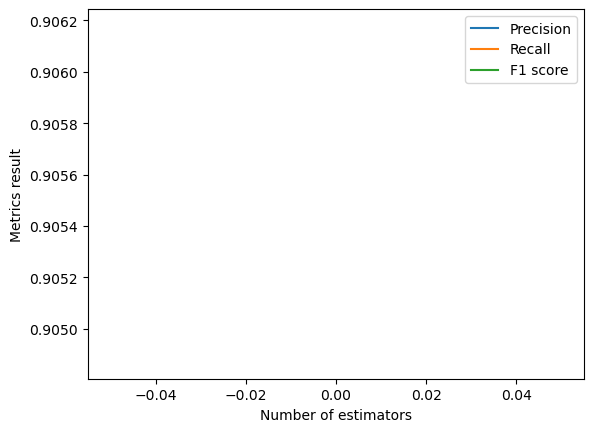

In [30]:
#n_estimators_range= range(1, 101)
plt.plot( precision, label='Precision')
plt.plot( recall, label='Recall')
plt.plot( f1, label='F1 score')
plt.xlabel('Number of estimators')
plt.ylabel('Metrics result')
#plt.title('Random Forest Performance')
#plt.ylim(0.2, 1.00)
plt.legend()
plt.show()

In [55]:
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
#plot_confusion_matrix(rf_classifier, X_test, y_test, display_labels=labels)
#plt.title('Confusion Matrix')
#plt.show()

Confusion Matrix:
[[287  11   0   2]
 [ 74 212  14   6]
 [  2   0 403   0]
 [  9   1   0 290]]


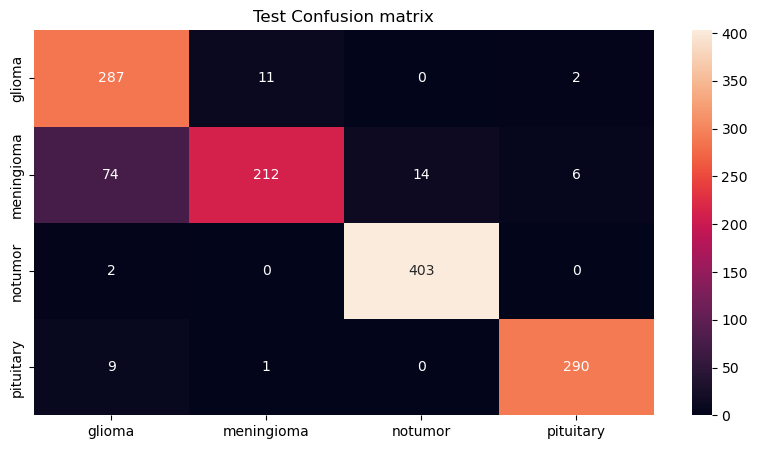

In [56]:
import seaborn as sn

plt.figure(figsize = (10,5))
CM = confusion_matrix(y_test, predicted_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, fmt=".0f", 
           annot_kws={"size": 10}, 
           xticklabels=class_names_label, 
           yticklabels=class_names_label, ax = ax)
ax.set_title('Test Confusion matrix')
plt.show()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_score = inv_model.predict(x_test)

41/41 [==============================] - 0s 6ms/step


In [58]:
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])

In [59]:
n_classes = y_test_bin.shape[1]

In [60]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

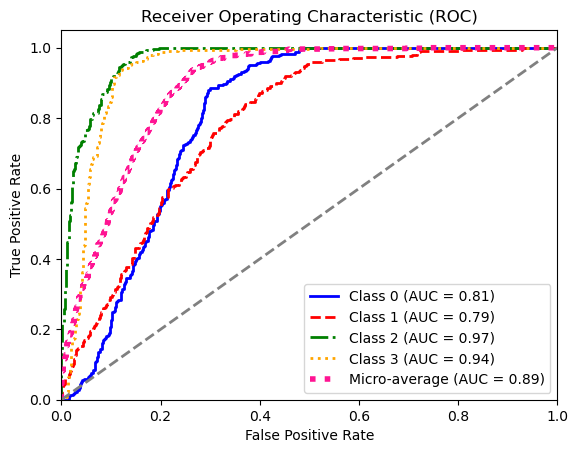

In [61]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])
line_styles = ['-', '--', '-.', ':']
for i, color,line_style in zip(range(n_classes), colors, line_styles):
    plt.plot(fpr[i], tpr[i], color=color, linestyle=line_style,lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=4,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))

# Plot random chance line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader) 
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])